# Context aware gate calibration notebook

This notebook proposes a full demonstration of how to use the context-aware gate calibration, leveraging only gate parameters.
Another notebook is available if one wants to deal with pulse level calibration.

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import sys

In [2]:
# Qiskit imports
from qiskit import transpile
from qiskit.circuit import (
    ParameterVector,
    QuantumCircuit,
    QuantumRegister,
)

from qiskit_ibm_runtime.fake_provider import (
    FakeJakartaV2,
    FakeJakarta,
)
from qiskit.circuit.library import CXGate

from rl_qoc.qconfig import QiskitConfig

from rl_qoc import ContextAwareQuantumEnvironment
from gymnasium.spaces import Box
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.distributions import Normal

import numpy as np
import tqdm
from typing import Optional
from IPython.display import clear_output

2024-06-21 14:17:50,321 - qm - INFO     - Starting session: 724331f7-564d-49de-b914-4ea18cde7697


In [3]:
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2

backend_name = "fake_armonk"
FakeProviderForBackendV2().backend(backend_name)

# Circuit macros for environment

In [4]:
def param_circuit(
        qc: QuantumCircuit,
        params: Optional[ParameterVector] = None,
        q_reg: Optional[QuantumRegister] = None,
        **kwargs
) -> None:
    my_qc = QuantumCircuit(q_reg, name="custom_cx")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )
    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    # my_qc.u(np.pi *params[0], np.pi *params[1], np.pi *params[2], 0)
    # my_qc.u(np.pi *params[3], np.pi *params[4], np.pi *params[5], 1)
    # my_qc.rzx(np.pi * params[6], 0, 1)
    qc.append(my_qc.to_gate(label="custom_cx"), physical_qubits)
    # qc.rx(2 * np.pi * params[0], physical_qubits)

# Definition of QuantumEnvironment

## Setting up Quantum Backend

### Simulation backend initialization
If you want to run the algorithm over a simulation, you can use both local (Qiskit Aer module or statevector simulation) and cloud simulators from IBM (Qiskit Runtime).

Below we define a gate level simulator instance mimicking a FakeBackend object. It can be either defined on the IBM cloud or locally.



#### Using ```FakeBackend``` as starting point

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_5204/1689285838.py:5: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  fake_backend = FakeJakarta()


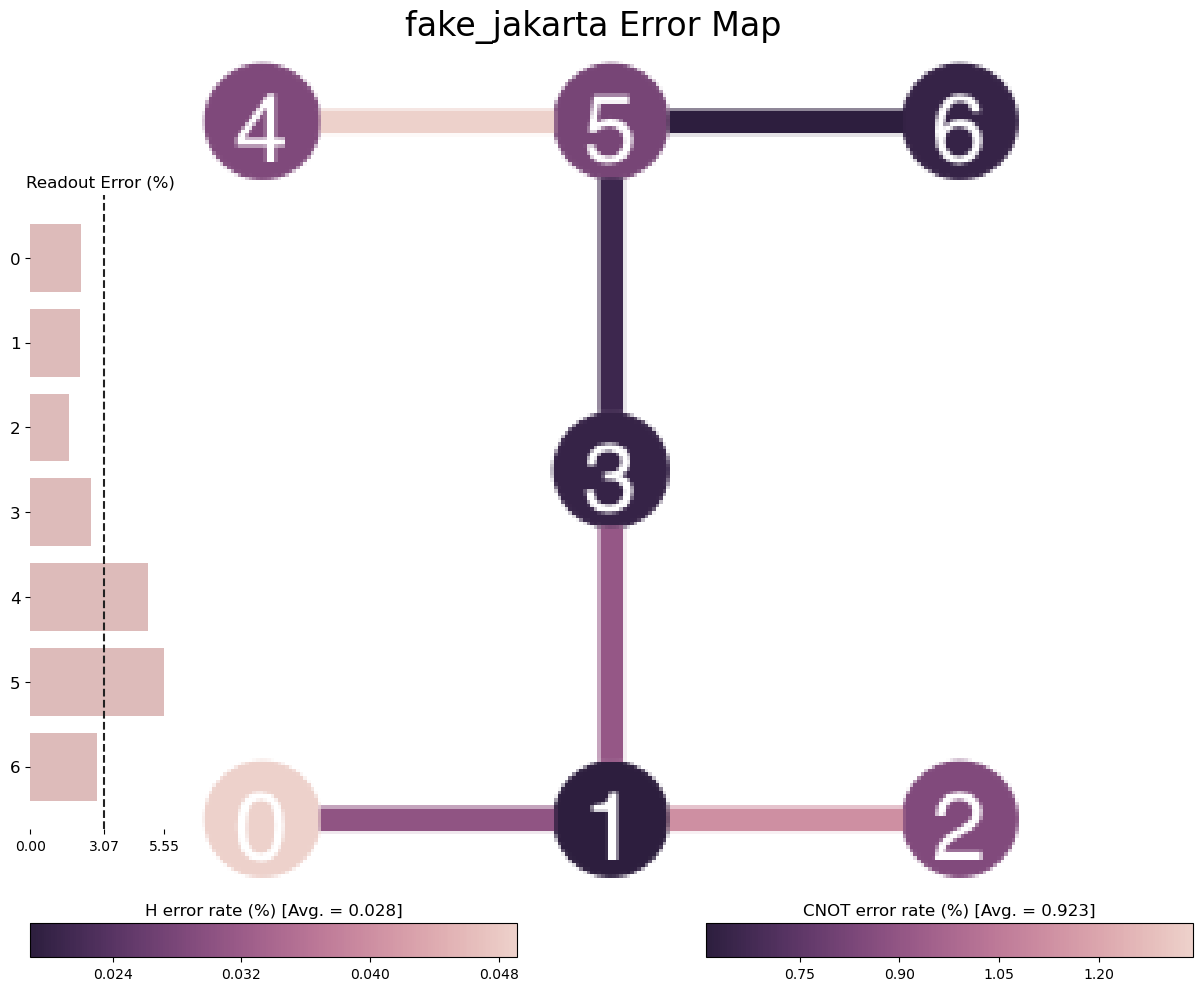

In [5]:
from qiskit.visualization import (
    plot_error_map,
)

fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
plot_error_map(fake_backend)

#### Choose Runtime Backend

Below, you can choose to run the simulations on IBM cloud instead of using the local Qiskit-Aer module. 

In [6]:
# Cloud simulator backend
from qiskit_ibm_runtime import QiskitRuntimeService, Options

estimator_options = Options()
service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")

## Choose backend and define Qiskit config dictionary
Below, set the Backend that you would like to run among the above defined backend.
Then define the config gathering all the components enabling the definition of the ```QuantumEnvironment```.



In [7]:
# Choose backend: local or in the cloud (runtime_backend or fake_backend_v2)
backend = fake_backend_v2
estimator_options = None

In [8]:
backend_config = QiskitConfig(
    parametrized_circuit=param_circuit,
    backend=backend,
    estimator_options=estimator_options,
)

## Target gate definition

Below we provide the necessary elements to define a target instruction to be calibrated within a specific circuit context. 

To do so we need:
1. A target gate, which we will pick as the CNOT gate, and a list of ```physical qubits``` on which it is applied. The algorithm will identify the ```CircuitInstruction``` object that is formed by the application of the gate on the specific set of qubits (that means that it will not calibrate instances of the gate on another set of qubits, an extension will enable in the future the simultaneous calibration of a target gate on non-overlapping qubits).
2. A ```QuantumCircuit``` instance involving the call of such gate.

*IMPORTANT*: To make sure that the gate we want to optimize will indeed be present in the transpiled circuit, make sure to first transpile the circuit yourself (with the method of your choice) before feeding the ```TorchQuantumEnvironment``` with it.

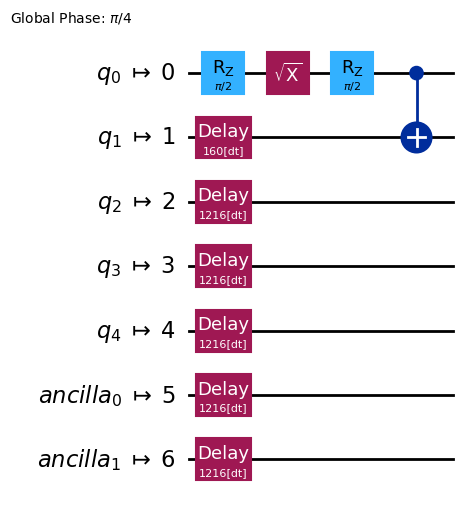

In [9]:
target_gate = CXGate()
physical_qubits = [0, 1]
target = {"gate": target_gate, "physical_qubits": physical_qubits}

target_circuit = QuantumCircuit(5)

target_circuit.h(0)
target_circuit.cx(0, 1)

target_circuit = transpile(
    target_circuit, backend, optimization_level=1, scheduling_method="asap"
)
target_circuit.draw("mpl")

## Generic information characterizing the environment

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- ```n_actions```: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit. For our pulse level ansatz, this number will depend on the number of parameters we are willing to tune in the original two-qubit gate calibration. For now we set it to 0, but will use the function ```count_parameters``` above to determine the number.
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```min_bound_actions```: Lower bound for the control parameters
- ```max_bound_actions```: Upper bound for the control parameters
- ```scale_factor```: Scaling factor for the control parameters
- ```observation_space```: The space of observations that the environment can return. It is a Box space, which is a generalization of the n-dimensional hypercube. It is defined by a shape attribute, which is a tuple of n floats, and a dtype attribute, which is the data type of the space's elements. The observation space is defined in this case by two numbers: the input state sampled at random (corresponding to a normalized index between 0 and 1) for the gate calibration, and the timing at which the target gate is applied in the circuit (we will provide a different gate calibration for each appearance). The latter timing is also normalized with respect to the total duration of the circuit.

In [10]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
sampling_Paulis = 200
N_shots = 20  # Number of shots for sampling the quantum computer for each action vector
n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
batchsize = 300
seed = 10
benchmark_cycle = 10  # Number of episodes before benchmarking the circuit fidelity
min_bound_actions = -0.05
max_bound_actions = 0.05
observation_space = Box(
    low=np.array([0, 0]),
    high=np.array([1, 1]),
    shape=(2,),
    seed=seed,
)
action_space = Box(
    low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed
)

# Definition of ```ContextAwareQuantumEnvironment```

Below we define our custom ```ContextAwareQuantumEnvironment``` to perform contextual gate calibration.


In [11]:
from rl_qoc.qconfig import QEnvConfig, ExecutionConfig

execution_config = ExecutionConfig(
    batchsize,
    sampling_Paulis,
    N_shots,
    n_reps=1,
    seed=seed,
)

env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    training_with_cal=False,
)

In [12]:
# Define necessary information for the Torch wrapper
training_steps_per_gate = (
    3  # How many training iterations allocated for each target gate in circuit
)

optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
env = ContextAwareQuantumEnvironment(
    env_config, target_circuit, training_steps_per_gate
)
env

QuantumEnvironment composed of 2 qubits, 
Defined target: gate (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]))
Physical qubits: [0, 1]
Backend: <qiskit_ibm_runtime.fake_provider.backends.jakarta.fake_jakarta.FakeJakartaV2 object at 0x10986ab90>,
Abstraction level: circuit,
Run options: N_shots (20), Sampling_Pauli_space (200), 
Batch size: 300, 

In [13]:
from gymnasium.wrappers import ClipAction, RescaleAction

rescaled_env = RescaleAction(ClipAction(env), -1.0, 1.0)

In [14]:
print("Backend options:\n", backend.options)

Backend options:
 Options(shots=1024, method='automatic', device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, enable_truncation=True, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=None, fusion_threshold=None, accept_distributed_results=None, memory=None, noise_model=None, seed_simulator=None, cuStateVec_enable=False, blocking_qubits=None, blocking_enable=False, chunk_swap_buffer_qubits=None, batched_shots_gpu=False, batched_shots_gpu_max_qubits=16, num_threads_per_device=1, shot_branching_enable=False, shot_branching_sampling_enable=False, statevector_parallel_threshold=14, statevector_sample_measure_opt=10, stabilizer_max_snapshot_probabilities=32, extended_stabilizer_sampling_method='resampled_metropolis', extended_stabilizer_metropolis_mixing_time=5000, extended_stabilizer_approximatio

In [15]:
print("Updated estimator options to account for the context:\n")
print(env.estimator.options)

Updated estimator options to account for the context:

Options(default_precision=0.015625, abelian_grouping=True, seed_simulator=None)


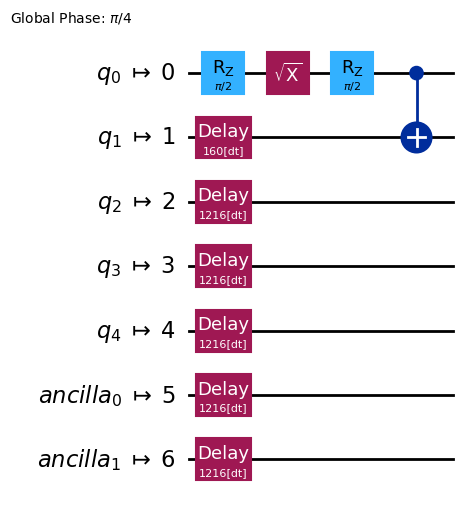

In [16]:
env.circuit_context.draw("mpl")

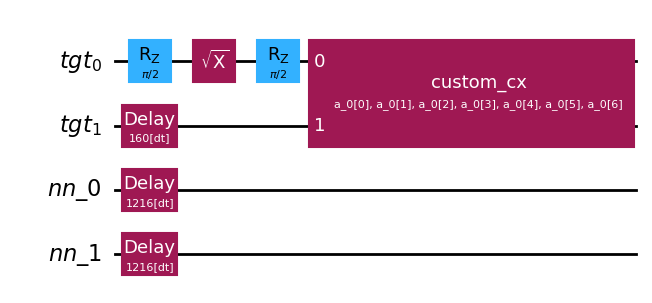

In [17]:
env.circuits[0].draw("mpl")

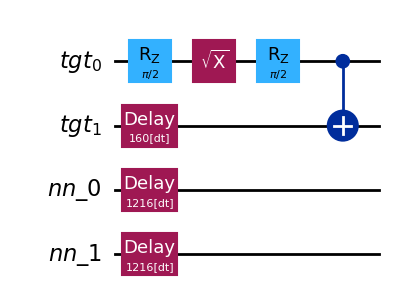

In [18]:
env.baseline_circuits[0].draw("mpl")

# Definition of the Agent

In [19]:
from rl_qoc.agent import ActorNetwork, CriticNetwork, Agent

hidden_units = [64, 64]
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
include_critic = True
chkpt_dir = "tmp/ppo"
chkpt_dir_critic = "tmp/critic_ppo"

actor_net = ActorNetwork(
    observation_space,
    hidden_units,
    n_actions,
    activation_functions,
    include_critic,
    chkpt_dir,
).to(device)
critic_net = CriticNetwork(
    observation_space, hidden_units, activation_functions, chkpt_dir_critic
).to(device)
agent = Agent(actor_net, critic_net=None).to(device)

## Hyperparameters for training

In [20]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""

run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.ad
# d_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 1000
opti = "Adam"
lr_actor = 0.0001  # Learning rate for policy update step
lr_critic = 0.0018  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.0
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.0

# Training
## Storage setup

In [21]:
tgt_instruction_counts = env.tgt_instruction_counts
global_step = 0
env.clear_history()
obs = torch.zeros((tgt_instruction_counts, batchsize) + env.observation_space.shape).to(
    device
)
actions = torch.zeros((tgt_instruction_counts, batchsize) + env.action_space.shape).to(
    device
)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros(
    (batchsize,) + env.observation_space.shape, requires_grad=True
).to(device)
visualization_steps = 10

## Main loop

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
from tensorboard import notebook

notebook.list()  # View open TensorBoard instances

In [ ]:
notebook.display(port=6006, height=1000)

In [ ]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = env.reset(seed=seed)
    num_steps = env.episode_length(global_step)
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            mean_action, std_action, critic_value = agent(next_obs)
            probs = Normal(mean_action, std_action)
            action = torch.clip(
                probs.sample(),
                torch.Tensor(np.array(min_bound_actions)),
                torch.Tensor(np.array(max_bound_actions)),
            )
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = rescaled_env.step(
            action.cpu().numpy()
        )
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = (
                    delta + gamma * gae_lambda * nextnonterminal * lastgaelam
            )
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(
                1
            ), new_dist.entropy().sum(1)
            logratio = (
                    new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            )
            ratio = logratio.exp()
            # print('new_logprob', new_logprob)
            # print('b_logprobs[mb_inds]', b_logprobs[mb_inds])
            # print("logratio", logratio)
            # print('ratio', ratio)
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                        mb_advantages.std() + 1e-8
                )

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    if env.do_benchmark():
        print("Circuit fidelity:", env.circuit_fidelity_history[-1])

        writer.add_scalar(
            "losses/circuit_fidelity",
            env.circuit_fidelity_history[-1],
            global_step,
        )
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar(
        "charts/learning_rate", optimizer.param_groups[0]["lr"], global_step
    )
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar(
        "losses/avg_return", np.mean(env.reward_history, axis=1)[-1], global_step
    )

    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step % visualization_steps == 0:
        clear_output(wait=True)  # for animation

env.close()
writer.close()

Fidelity stored 0.9752602272662713
Sending Estimator job...


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/base_q_env.py:1123: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]
 62%|██████▏   | 621/1000 [25:21<15:27,  2.45s/it]

Finished Estimator job
mean tensor([ 0.6890,  0.0608,  0.0007,  0.2455, -0.2113,  0.1676, -0.5138])
sigma tensor([0.6456, 0.4262, 0.3454, 0.4915, 0.4158, 0.4273, 0.5976])
Average return: 0.43871052631578966
Circuit fidelity: 0.9752602272662713
Fidelity stored 0.9752603163239644
Sending Estimator job...


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/base_q_env.py:1123: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]
 62%|██████▏   | 622/1000 [25:24<16:39,  2.64s/it]

Finished Estimator job
mean tensor([ 0.6885,  0.0637,  0.0018,  0.2461, -0.2097,  0.1663, -0.5116])
sigma tensor([0.6462, 0.4260, 0.3455, 0.4907, 0.4159, 0.4276, 0.5975])
Average return: 0.44310241214945295
Circuit fidelity: 0.9752603163239644


In [ ]:
env.close()
writer.close()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(env.circuit_fidelity_history, label="Circuit fidelity")
plt.plot(np.mean(env.reward_history, axis=1), label="Average return")
plt.legend()

In [ ]:
plt.plot(np.mean(env.reward_history, axis=1))